## Importing the libraries

In [1]:
from bs4 import BeautifulSoup
import requests
import json
import pandas as pd
import numpy as np
import re
import os
import csv

In [2]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=FutureWarning)
warnings.filterwarnings("ignore",category=UserWarning)
warnings.filterwarnings("ignore",category=RuntimeWarning)

In [3]:
test_data = pd.read_csv('/content/ResultSheet.csv')

In [4]:
test_data.head(5)

,Serial Number,File_Name,URL,Tokenized_Text,Actual Topic,Predicted Topic,Success,Topic_Distribution,Unnamed: 8,Topic_Assignment
0,1,thehindu_jan_8_file_235.json,https://www.thehindu.com/news/cities/Hyderabad...,"['pact', 'open', 'access', 'manuguru', 'solar'...","Electrical Power Industry, Politics",17-Politics(34%) 4-Medical Health(59%),1,"([(4, 0.59516954), (17, 0.34324005)], [(0, [4,...",NaN,NaN
1,2,thehindu_jan_1_file_388.json,https://www.thehindu.com/news/cities/mumbai/st...,"['stamp', 'duty', 'rise', 'revenue', 'waiver',...","Politics, National News",17-Politics(37%) 7-Infectious Diseases(29%),1,"([(2, 0.04028918), (4, 0.029873291), (6, 0.023...",NaN,NaN
2,3,thehindu_jan_5_file_74.json,https://www.thehindu.com/news/national/sourav-...,"['stable', 'cardiologist', 'devi', 'meet', 'te...","Medical Industry, Cricket",7-Infectious Diseases(31%) 17-Politics(16%),1,"([(0, 0.1190001), (1, 0.041758973), (2, 0.0304...",NaN,NaN
3,4,thehindu_jan_6_file_24.json,https://www.thehindu.com/news/international/ab...,"['china', 'escalates', 'hong_kong', 'crackdown...","Protests & Conflicts, Politics, Internatinal News",0-Movies(25%) 11-War & Conflicts(21%) ...,1,"([(0, 0.2525065), (1, 0.055646397), (4, 0.0308...",NaN,NaN
4,5,thehindu_jan_12_file_198.json,https://www.thehindu.com/news/national/telanga...,"['erravalli', 'village', 'wear', 'deserted', '...",Construction Industry,13-Construction Industry(45%) 17-Politics(14%),1,"([(0, 0.018467413), (2, 0.011356237), (7, 0.03...",NaN,NaN


### Creating a list of URLs

In [5]:
url_list = test_data['URL']

In [6]:
url_list

0     https://www.thehindu.com/news/cities/Hyderabad...
1     https://www.thehindu.com/news/cities/mumbai/st...
2     https://www.thehindu.com/news/national/sourav-...
3     https://www.thehindu.com/news/international/ab...
4     https://www.thehindu.com/news/national/telanga...
                            ...                        
70    https://www.thehindu.com/opinion/op-ed/buildin...
71    https://www.thehindu.com/elections/andhra-prad...
72    https://www.thehindu.com/news/cities/Mangalore...
73    https://www.thehindu.com/news/national/kerala/...
74    https://www.thehindu.com/opinion/open-page/rei...
Name: URL, Length: 75, dtype: object

In [7]:
json_files = []
for i in range(75):
  json_files.append('thehindu_feb_02_file_{0}.json'.format(i))

## Scraping the useful content from the URLs

In [8]:
for i in range(75):
  news_data = {"text" : []}
  page = requests.get(url_list[i])
  soup = BeautifulSoup(page.content, "html.parser")

#SCRAPING THE TITLE OF THE WEBPAGE
  title = soup.find('h1')
  if title!= None:
    news_data["text"].append(title.text)

#SCRAPING THE SUB TITLE OF THE WEBPAGE
  sub_title = soup.find_all('h2')
  if sub_title != None:
    for st in sub_title:
      news_data["text"].append(st.text)

      
#SCRAPING CONTENT FROM PARAGRAPH TAGS WITH A SPECIFIC ID
  regex = re.compile('.*content-body-.*')
  for item in soup.find_all("div", {'id': regex}):
    for p in item.find_all('p'):
      news_data["text"].append(p.text)  

#STORING THE CONTENT FROM EACH WEBPAGE IN A SEPARATE JSON FILE
  with open(json_files[i], 'w') as jsonfile:
    json.dump(news_data, jsonfile)

#SAVING THE JSON FILES IN GOOGLE DRIVE
  !cp {json_files[i]} /content/drive/MyDrive/TEST

RAW TEXT

In [9]:
raw_text = []
for js in json_files:
   with open(js) as json_file:
        json_text = json.load(json_file)
        raw_text.append(json_text['text'])

In [11]:
with open('raw_text_test2.json', 'w') as jsonfile:
   json.dump(raw_text, jsonfile)
!cp raw_text_test2.json /content/drive/MyDrive/RAW_TEXT

## Data Preprocessing

In [12]:
#FOR STOP WORDS
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

#FOR LEMMATIZATION
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

#FOR STEMMING
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

#FOR BIGRAMS
from nltk.util import bigrams
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [13]:
def data_preprocessing(raw_text):
  filtered_text = []     #TO STORE THE PROCESSED DATA    
  for t in raw_text:
    filtered_sentence = ""
    stemmed_list = []
    lemmatized_list = []
    
    sentence = str(t)
    # Remove new line characters
    for word in sentence:
      word = word.strip()

    #Data Cleansing
    sentence = re.sub(r'[^\w\s]', ' ', sentence)


    #Removing numbers
    sentence = re.sub(r'[0-9]', '', sentence)
    
    #Tokenization
    words = nltk.word_tokenize(sentence)

    #Lowercase
    for word in words:
      word.lower()
    
    #Stop words removal
    words = [w for w in words if not w in stop_words]
    
    #Stemming
    for word in words:
        stemmed_word = stemmer.stem(word)
        stemmed_list.append(stemmed_word)
        
    #Lemmatization
    for s_word in stemmed_list:
        lemmatized_word = lemmatizer.lemmatize(s_word)
        lemmatized_list.append(lemmatized_word)

    
    lemmatized_list = [i for i in lemmatized_list if len(i) > 3]
    
    filtered_text.append(lemmatized_list)
  return filtered_text

In [14]:
filtered_text = data_preprocessing(raw_text)

### Frequency Distribution

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import FreqDist
# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

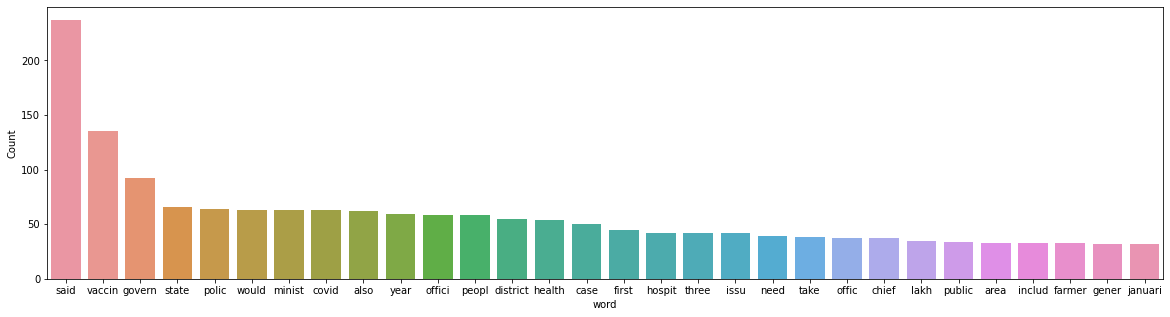

In [16]:
words_list = []
for line in filtered_text:
  for word in line:
    words_list.append(word)
freq_words(words_list)


In [21]:
extra_stopwords = [ 'said', 'would', 'also', 'first','last','three','need','time','even', 'issu', 'lakh', 'area', 'includ', 'januari', 'year', 'take', 'crore', 'meet']
stop_words.extend(extra_stopwords)

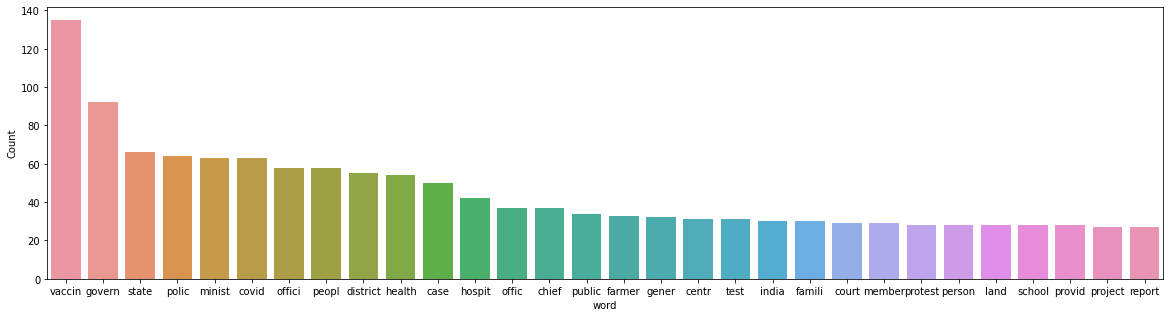

In [22]:
words_list = [w for w in words_list if not w in stop_words]
freq_words(words_list)

In [23]:
filtered_text2 = []
for sentence in filtered_text:
  sentence = [w for w in sentence if not w in extra_stopwords]
  filtered_text2.append(sentence)

Wordcloud

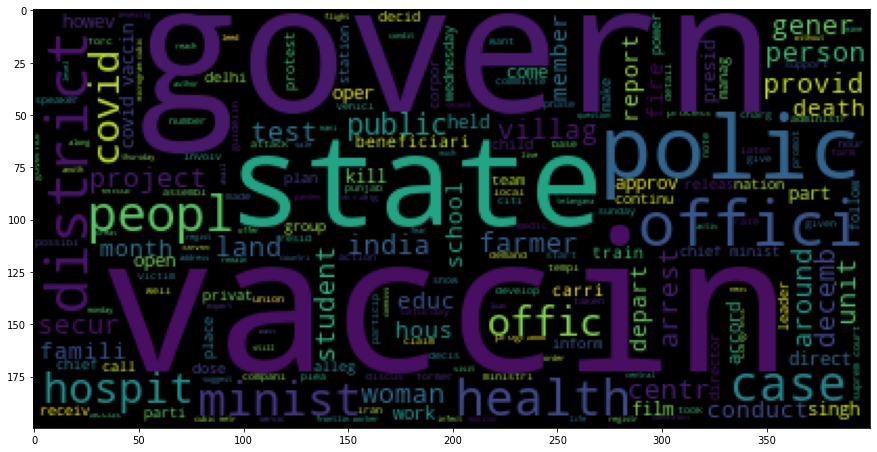

In [24]:
words_string = " ".join(words_list)
import wordcloud

wordcloud = wordcloud.WordCloud()
wordcloud.generate(words_string)
plt.figure( figsize=(15,10) )
plt.rcParams["axes.grid"] = False
plt.imshow(wordcloud)

### Bigrams Formation

In [25]:
# Compute bigrams.
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 25 times or more).
bigram = Phrases(filtered_text2, min_count=25)
for idx in range(len(filtered_text2)):
    for token in bigram[filtered_text2[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            filtered_text2[idx].append(token)

### Saving the Filtered Text

In [27]:
#TO SAVE THE FILTERED TEXT IN A JSON FILE
with open('filtered_text_test2.json', 'w') as jsonfile:
   json.dump(filtered_text2, jsonfile)
!cp filtered_text_test2.json /content/drive/MyDrive/RAW_TEXT

Importing the training set used for model building to build the corpus and dictionary.

In [32]:
train = []
f1 = open("/content/drive/MyDrive/RAW_TEXT/training_set.json")
data1 = json.load(f1)
for i in data1:
  train.append(i)

In [28]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [33]:
id2word = corpora.Dictionary(train)

#Removing very rare words
id2word.filter_extremes(no_below=20, no_above=0.5)

# Create Corpus
texts = train

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

### Loading the saved model

In [34]:
from sklearn.externals import joblib
lda_model = joblib.load(open('/content/drive/MyDrive/Models/final_model.pkl', 'rb'))

## Topic Distribution

In [35]:
Topic_distribution= []
for i in range(75):
  print(lda_model[id2word.doc2bow(filtered_text[i])][0])
  Topic_distribution.append(lda_model[id2word.doc2bow(filtered_text[i])][0])

[(0, 0.02215596), (6, 0.04423298), (8, 0.16553806), (9, 0.15851201), (10, 0.11870696), (12, 0.106953256), (13, 0.3787056)]
[(0, 0.13025634), (6, 0.5703095), (7, 0.1739922), (11, 0.11791374)]
[(0, 0.3811501), (2, 0.14989173), (3, 0.06169087), (4, 0.04806358), (5, 0.037703544), (7, 0.084404536), (11, 0.04033169), (12, 0.19272883)]
[(1, 0.053704444), (2, 0.0145022), (4, 0.16218741), (5, 0.11105428), (8, 0.124418385), (12, 0.49655327), (13, 0.032319043)]
[(3, 0.19786471), (4, 0.07629761), (5, 0.06394417), (7, 0.10992962), (11, 0.2435185), (12, 0.021528954), (13, 0.28283298)]
[(4, 0.040643737), (6, 0.070811875), (7, 0.4431531), (9, 0.43735683)]
[(0, 0.08749136), (3, 0.12644841), (7, 0.10059229), (9, 0.20957987), (10, 0.33340535), (11, 0.06530428), (13, 0.072569326)]
[(4, 0.48549178), (5, 0.33328345), (7, 0.16017525), (11, 0.010647725)]
[(0, 0.21398753), (3, 0.08586292), (7, 0.26846066), (9, 0.4237748)]
[(0, 0.026490007), (3, 0.020369742), (7, 0.098244116), (9, 0.039577927), (11, 0.20961605)

In [36]:
test = pd.DataFrame(zip(Topic_distribution))
test.to_csv('Test_TD.csv')